<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/01-Pandas/A1-Introduction_Descriptive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Pandas

## Setup and preliminaries

Install the necessary libraries to connect to MySQL and to read Excel files

In [1]:
!pip3 install -U -q PyMySQL sqlalchemy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 296.7 kB/s eta 0:00:00


In order to read and process files, we are going to use a very powerful, and widely used Python library, called pandas. So, our next step is to import the pandas library in Python, and a few related libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

And we type some code to simply change the visual style of the plots. (The code below is optional and not necessary, and for now you do not need to understand what exactly is happening.)

In [5]:
# Render our plots with high resolution
%config InlineBackend.figure_format = 'retina'
# Make the graphs a bit bigger
matplotlib.style.use(["seaborn-v0_8-talk", "seaborn-v0_8-ticks", "seaborn-v0_8-whitegrid"])
# Setting the default figure size for Pandas plots
pd.options.plotting.backend = 'matplotlib'
plt.rcParams['figure.figsize'] = [10, 3]

# Loading Data

Pandas offers the ability to read and write from/to many different data types. We read from a MySQL server using SQL in this notebook.

Later, we will discuss [more examples](https://github.com/ipeirotis/dealing_with_data/blob/master/01-Pandas/B1-Pandas_Reading_Data.ipynb), showing how to download and read CSV files, Excel files, fixed-width datasets, and even how to read directly tables from web pages.

The [official documentation](https://pandas.pydata.org/docs/reference/io.html) has the full list.

## Reading data using SQL from a MySQL Server

We will use a dataset with [restaurant inspection results in NYC](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j). The dataset that we are going to use has been cleaned up, normalized, and stored in our MySQL database, under the `doh_restaurants` database.

In [6]:
import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2025',
    db = 'doh_restaurants',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)

We fetch the results of the query using the `read_sql` command. This command executes the SQL query and returns the result as a Pandas **DataFrame**. A DataFrame is effectively a table in Pandas. Each DataFrame contains multiple columns: Each column in Pandas is called a **Series**.

This part is the connecting point between databases and Python: We fetch the **necessary** (and not all) data into Python Pandas, and then we proceed to do analysis, manipulation, and visualizations that would be cumbersome or impossible in SQL alone.

In [44]:
# This query returns back the restaurants in the DOH database
sql = '''
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO,
          R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE
		FROM doh_restaurants.restaurants R
'''

with engine.connect() as connection:
	restaurants = pd.read_sql(text(sql), con=connection)

In [8]:
# This query returns back the results of the inspections of each restaurant
sql = '''
	SELECT R.CAMIS, R.DBA, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION,
				 I.INSPECTION_DATE, I.INSPECTION_ID,
				 I.INSPECTION_TYPE, I.SCORE, I.GRADE
	FROM restaurants R
		JOIN inspections I ON I.CAMIS = R.CAMIS
'''

with engine.connect() as connection:
	inspections = pd.read_sql(text(sql), con=connection)

In [9]:
# This query returns back the results and violations captured in the
# latest inspection of each restaurant
sql = '''
  WITH latest_inspection AS (
		SELECT CAMIS, MAX(INSPECTION_DATE) AS INSPECTION_DATE FROM inspections
		GROUP BY CAMIS
	)
	SELECT R.CAMIS, R.DBA, R.ZIPCODE, R.BORO,
          I.INSPECTION_DATE, I.INSPECTION_ID, I.INSPECTION_TYPE,
          V.VIOLATION_CODE, I.SCORE, I.GRADE
		FROM restaurants R
			JOIN latest_inspection L ON R.CAMIS = L.CAMIS
			JOIN inspections I ON I.CAMIS = L.CAMIS AND L.INSPECTION_DATE = I.INSPECTION_DATE
			JOIN violations V ON I.INSPECTION_ID = V.INSPECTION_ID
'''

with engine.connect() as connection:
	violations = pd.read_sql(text(sql), con=connection)

When you run your query using Pandas, you get back a kind of object called a DataFrame, which is made up of rows and columns. Let's take a look at how the object looks like:

In [10]:
restaurants

,CAMIS,DBA,BUILDING,STREET,ZIPCODE,BORO,CUISINE_DESCRIPTION,LATITUDE,LONGITUDE
0,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVENUE,10462,Bronx,Bakery Products/Desserts,40.8482,-73.8560
1,30191841,D.J. REYNOLDS,351,WEST 57 STREET,10019,Manhattan,Irish,40.7673,-73.9843
2,40356018,RIVIERA CATERERS,2780,STILLWELL AVENUE,11224,Brooklyn,American,40.5799,-73.9821
3,40356483,WILKEN'S FINE FOOD,7114,AVENUE U,11234,Brooklyn,Sandwiches,40.6201,-73.9070
4,40356731,TASTE THE TROPICS ICE CREAM,1839,NOSTRAND AVENUE,11226,Brooklyn,Frozen Desserts,40.6408,-73.9485
...,...,...,...,...,...,...,...,...,...
21017,50162012,MAXIME'S,828,MADISON AVENUE,10021,Manhattan,Mediterranean,40.7699,-73.9668
21018,50162159,SIDEBAR CAFE,891,SHERIDAN AVENUE,10451,Bronx,Other,40.8268,-73.9209
21019,50162257,MRS GREEN SALAD & JUICE,328,EAST 14 STREET,10003,Manhattan,Salads,40.7319,-73.9839
21020,50163768,A BITE OF FUZHOU,4009,PRINCE ST,11354,Queens,Chinese,40.7588,-73.8318


In [ ]:
# If you want the first 6 lines:
# restaurants.head(6)

In [ ]:
# If you want the last 10 lines:
# restaurants.tail(10)

### Exercise: Playing with dataframes (aka tables)

Inspect the contents of the `inspections` and `violations` dataframes

In [ ]:
# Your code here

In [ ]:
# Your code here

### Exercise:  Connect to a database using read_sql

Create a dataframe called `manh_rest` that contains the restaurants located in Manhattan, which mirrors the `restaurants` dataframe but is limited to only restaurants in Manhattan. You need to write the appropriate SQL query and get back the data that you need.

Also create a dataframe called `manh_insp` that contains inspections just for Manhattan restaurants.

We will use these dataframes later on for more exercises.

In [ ]:
# Your code here

# Data Types and Descriptive Statistics

We will see that we have different approaches for analyzing different data types. We treat textual data different than numeric data, and date/time data have  differnt techniques than numeric data. For that, it is important to know the data type of each column, to ensure that we can perform the right analysis.

## Data Types using `.dtypes`

We can also check the data types for each column

In [11]:
restaurants.dtypes

,0
CAMIS,object
DBA,object
BUILDING,object
STREET,object
ZIPCODE,object
BORO,object
CUISINE_DESCRIPTION,object
LATITUDE,float64
LONGITUDE,float64


### Exercise: Data Types

Get the data types for the "inspections" and "violations"

In [15]:
# your code here

## Descriptive statistics



### Descriptive Statistics for Numeric Variables


#### Basic descriptive statistics for numeric variables

Given that SCORE is a numeric variable, we can get more detailed descriptive statistics for the variable using the `.describe()` command:

In [12]:
inspections["SCORE"].describe()

,SCORE
count,59383.000000
mean,16.976475
std,13.158337
min,0.000000
25%,9.000000
50%,12.000000
75%,22.000000
max,154.000000


#### Histograms for Numeric Data

And now that SCORE is a numeric variable, we can examine its distribution by using the `hist` command of Pandas, which creates a histogram. (The histogram is lso available as `.hist`, or `plot(kind='hist'))`.)

<Axes: ylabel='Frequency'>

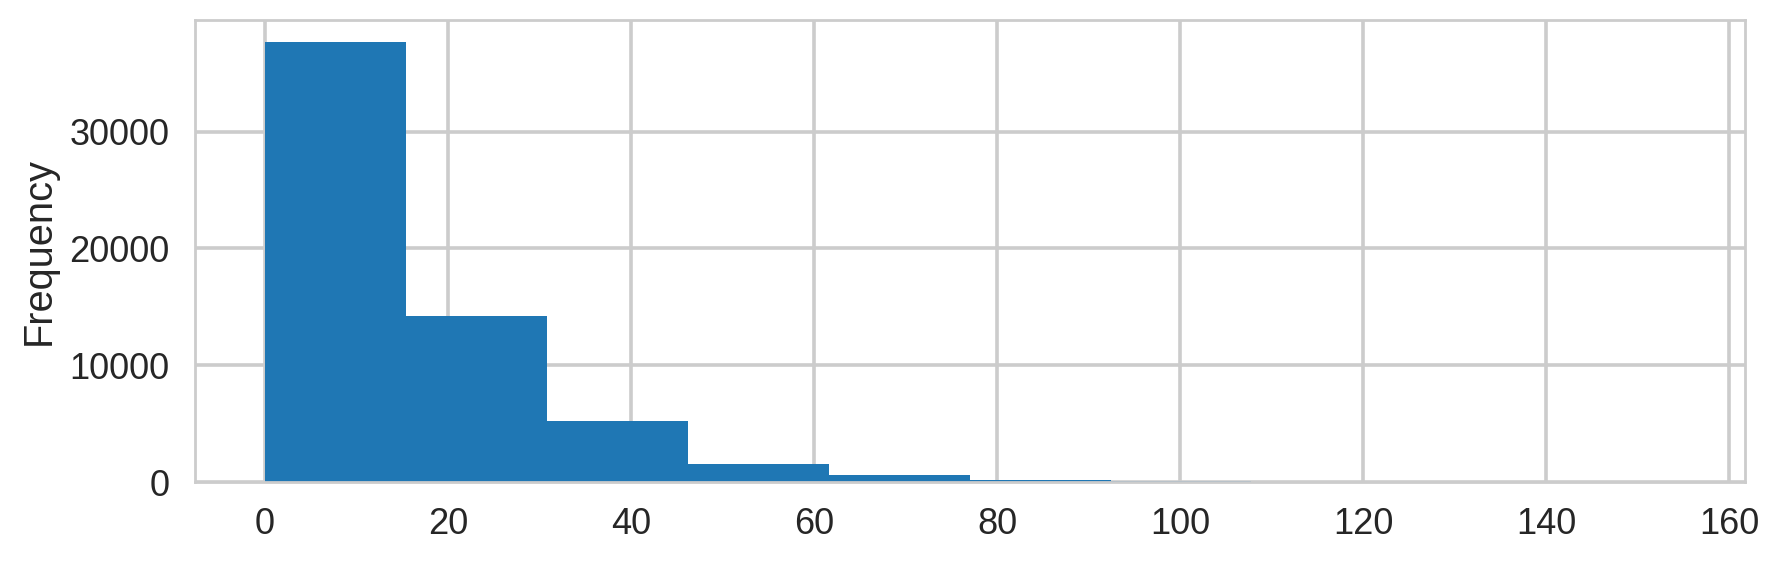

In [13]:
inspections["SCORE"].plot.hist()

By default, the histogram has ~10 bars in out plot. We can change the resolution of the histogram using the `bins` variable. Larger number of `bins` allow for higher resolution, but if we increase the number too much, many bins end up having very few, or no data points. For example, experiment with changing the balue of bins below, and change the value from 50 to something bigger.

In [ ]:
inspections["SCORE"].plot.hist(bins=50)

The cumulative option allows us to see how many entries have scores below a particular value.

In [ ]:
inspections["SCORE"].plot.hist(bins=50, cumulative=True)

<Axes: title={'center': 'Histogram of inspection score values'}, xlabel='Inspection Score', ylabel='Count of inspections'>

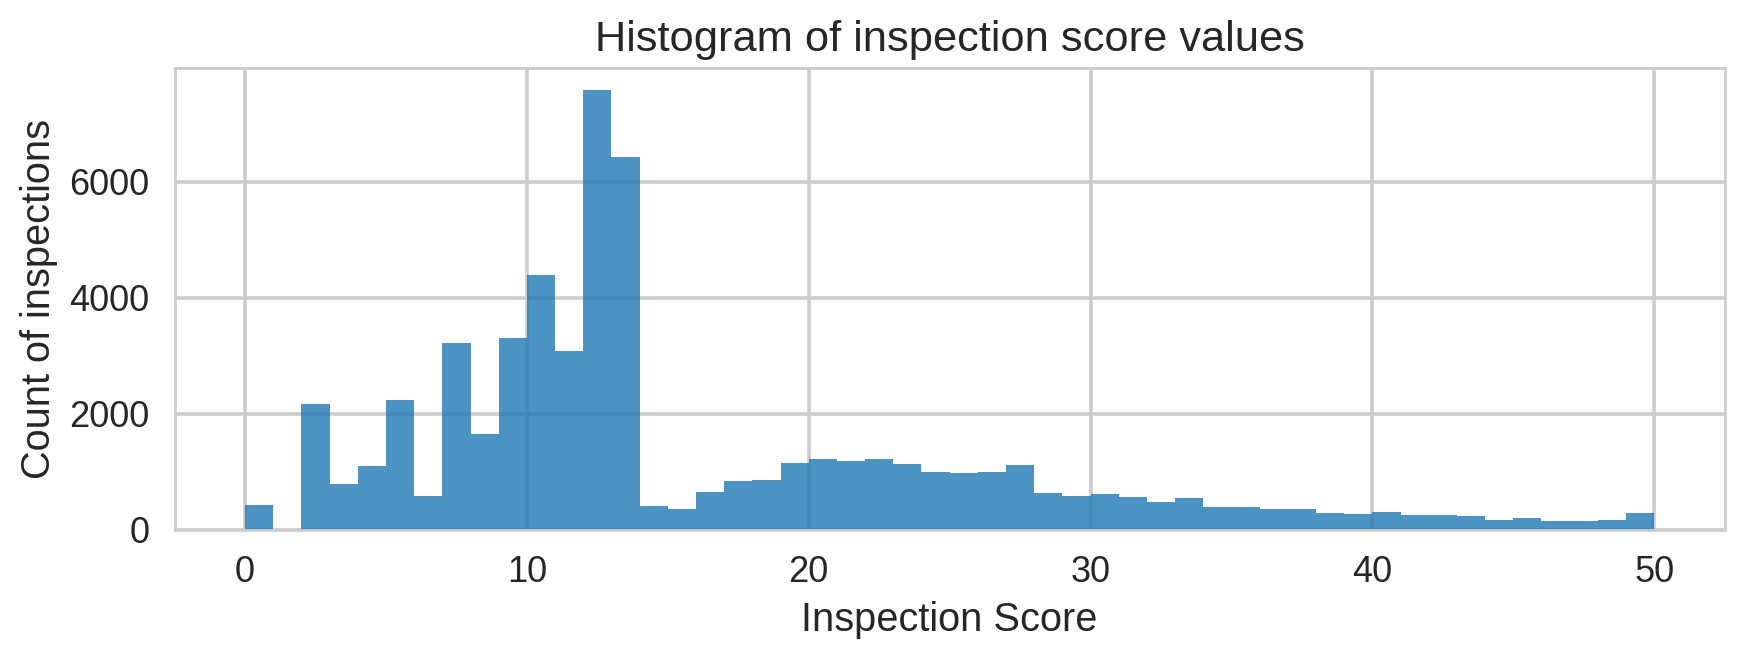

In [50]:
# A quick exposure to various options of the "hist" command
inspections["SCORE"].plot.hist(
    bins=50,  # use 50 bars
    range=(0, 50),  # only consider scores from 0 to 50
    density=False,  # show normalized count (density=True), or raw counts (density= False)
    figsize=(10, 3),  # controls the size of the plot
    alpha=0.8,  # make the plot 20% transparent
    title="Histogram of inspection score values",
    xlabel="Inspection Score",
    ylabel="Count of inspections"
)

<Axes: title={'center': 'Percentage of Inspection Scores with Lower Score'}, xlabel='Inspection Score', ylabel='Percentage of inspections'>

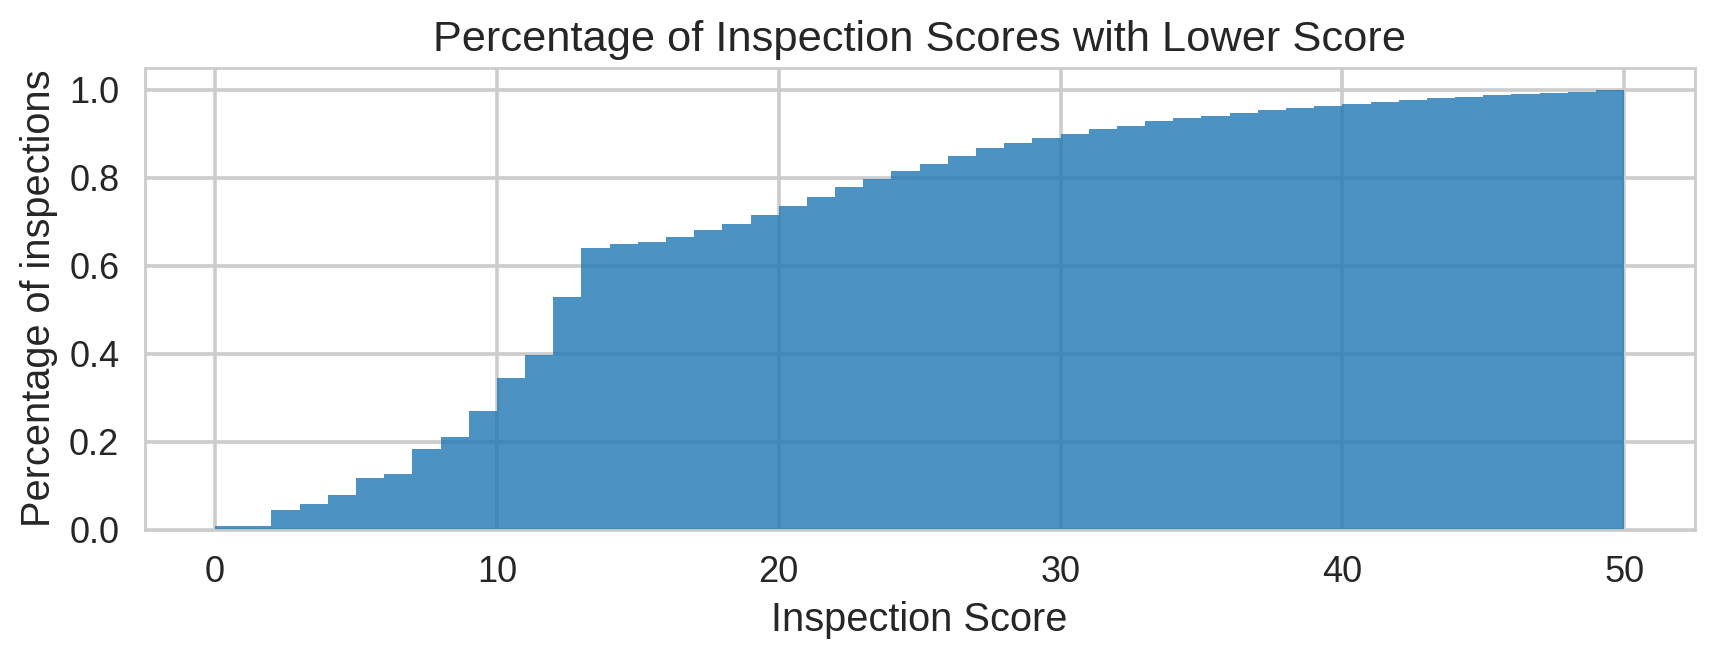

In [53]:
# Changing plot to cumulative
inspections["SCORE"].plot.hist(
    bins=50,  # use 50 bars
    range=(0, 50),  # only consider scores from 0 to 50
    density=True,  # show normalized count (density=True), or raw counts (density= False)
    cumulative=True, # change the histogram to be cumulative
    figsize=(10, 3),  # controls the size of the plot
    alpha=0.8,  # make the plot 20% transparent
    title="Percentage of Inspection Scores with Lower Score",
    xlabel="Inspection Score",
    ylabel="Percentage of inspections"
)

#### Exercise: Histograms

* Create the corresponding histograms for the `manh_insp` dataframe that we created earlier. Some people claim that Manhattan restaurants are favored by the inspectors and get lower scores. Do you agree?

* Create histograms for the `LONGITUDE` and `LATITUDE` variables from the `restaurants` dataframe.

* Create histograms for the `LONGITUDE` and `LATITUDE` variables from the `manh_rest` dataframe.

In [ ]:
# your code here

#### Kernel Density Estimation (KDE)

An alternative to histograms is to use the **kernel density**, which estimates a continuous function, instead of the bucketized counts, which tends to be discontunuous and bumpy. We can access this usind the [`.plot(kind='kde')`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.kde.html) command:

In [ ]:
# This plots the density of a numeric attribute
# kde = kernel density estimation
inspections["SCORE"].plot(kind="kde", color="Black", xlim=(0, 50), figsize=(10, 3))

#### Extra: Combining plots

Just as a quick note, we can actually easily combine plots in Pandas, by saving a plot in a variable, and then passing the parameter `ax = ....` in the new figure that we are creating. That `ax` parameter indicates that we want to plot the new chart on top of the plot specified in the `ax` parameter.

In [ ]:
# We save the plot in the variable "histogram_figure"
histogram_figure = inspections["SCORE"].plot.hist(
    bins=50,  # use 50 bars
    range=(0, 50),  # x-axis from 0 to 50
    density=True,  # show normalized count (density=True), or raw counts (density= False)
    figsize=(10, 3),  # controls the size of the plot
    alpha=0.8,  # make the plot 20% transparent
)

# To combine the plots, we pass the ax = histogram_figure parameter
inspections["SCORE"].plot(
    kind="kde",
    color="Black",
    xlim=(0, 50),
    figsize=(10, 3),
    ax=histogram_figure # <<== We plot this figure on top of "histogram_figure"
)

#### Exercise: Create a KDE plot

* Combine the KDE plots for the `SCORE` variable from the `inspections` dataframe and the `manh_insp` dataframe.
* Change the color of the line for one of the two data sources, so that you can see easier the difference between the two.
* Add a bit of transparency to the lines so that you can avoid covering one line fully by the other.

#### Extra 2: Plotting Geographical Position

The code below illustrates how to plot the geographical location of the restaurants. We use a `scatterplot` plot, and we use the `LONGITUDE` and `LATITUDE` as variables to place the dots of the scatterplot.

In [ ]:
restaurants.plot(
    kind = 'scatter',
    x = 'LONGITUDE',
    y = 'LATITUDE',
    c = 'Red', # sets the color for the dots
    # s = 0.25, # keep the size of each dot small
    # figsize = (8,8), # resise the figure
    # alpha = 0.5 # make dots transparent
)

#### Extra 3: Plotting Geographical Boundaries

The plot below is mainly for illustrative purposes right now. We will dive deeper in these techniques when working on spatial data.

<Axes: >

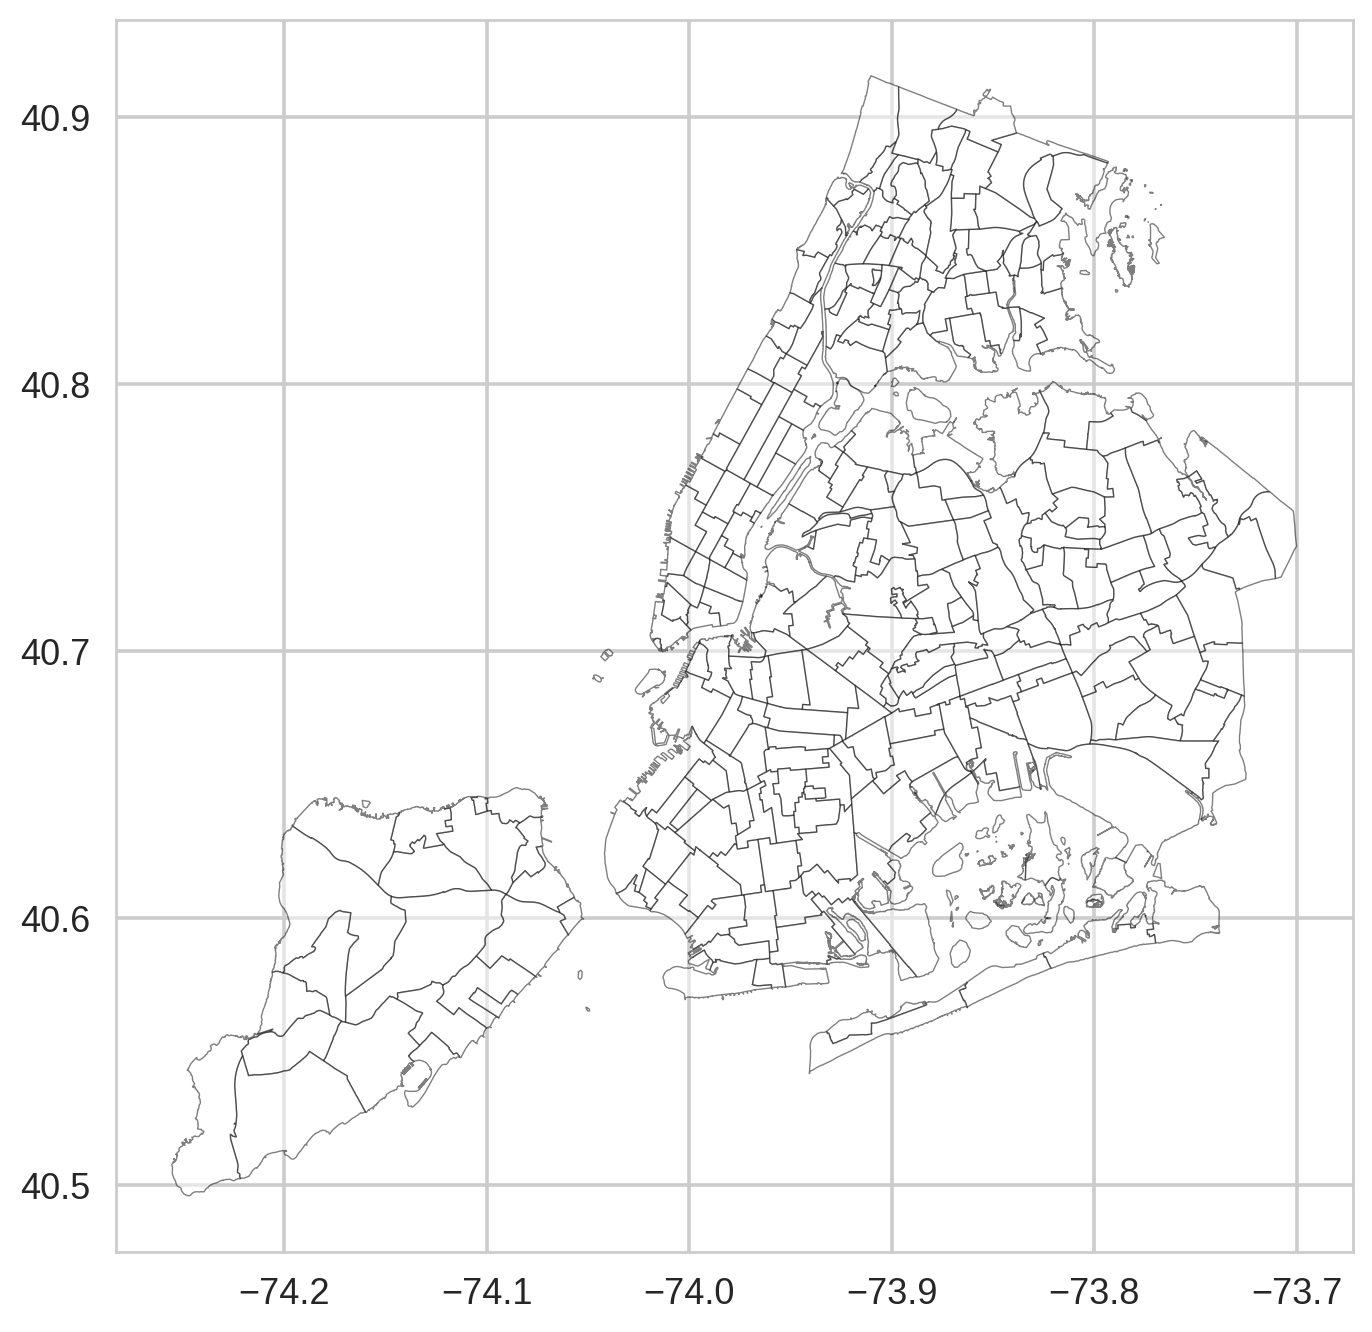

In [19]:
import geopandas as gpd

# This code downloads a dataset with the neighborhoods of NYC
# and plots their outlines.

# Dataset from NYC Open Data: https://www.nyc.gov/content/planning/pages/resources/datasets/neighborhood-tabulation
map_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Neighborhood_Tabulation_Areas_2020/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
df_nyc = gpd.GeoDataFrame.from_file(map_url)

df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(8, 8),
    alpha=0.5
)

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

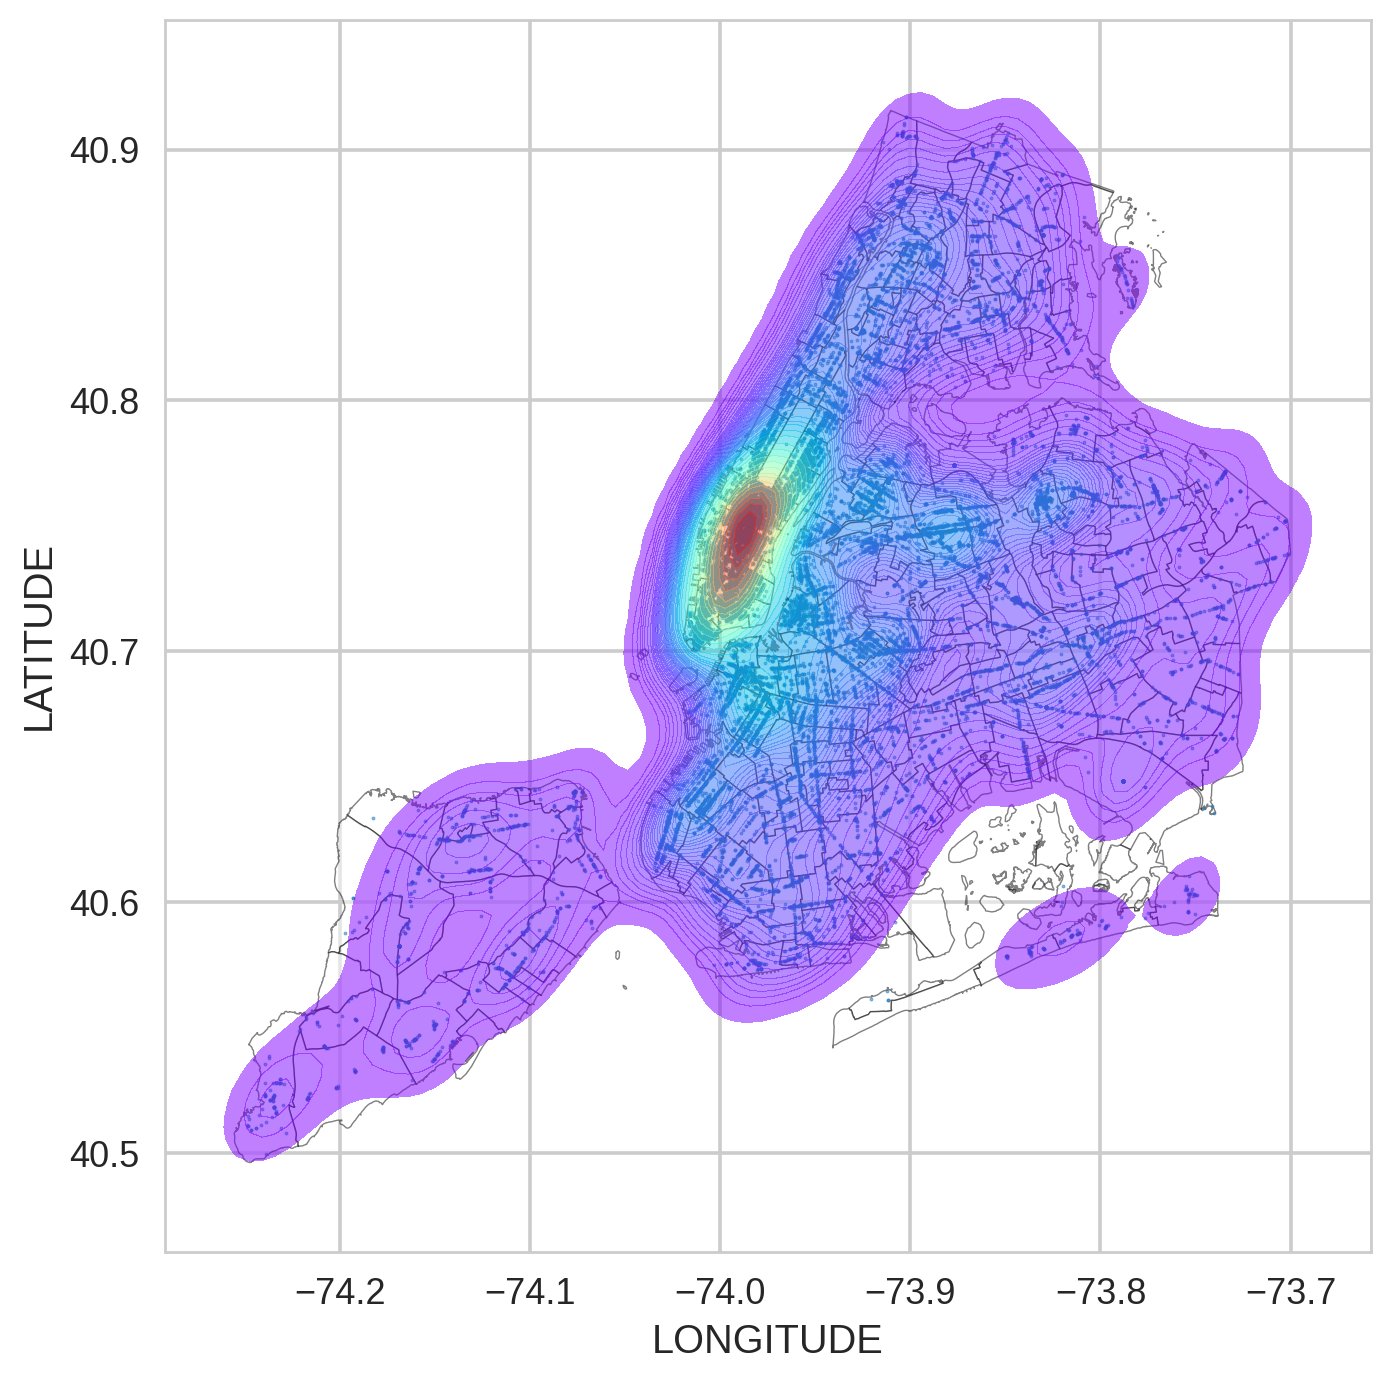

In [20]:
# this is the map of NYC neighborhoods, that we use as the first
# layer of our plot
base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(8, 8),
    alpha=0.5)

# On a second layer, we plot a scatterplot with the locations of the
# restaurants
scatter = restaurants.plot(
    kind = 'scatter',
    x = 'LONGITUDE',
    y = 'LATITUDE',
    s = 1, # keep the size of each dot small
    # figsize = (10,10), # resize the figure
    alpha = 0.5, # make dots transparent
    ax = base # we create this plot on top of the first layer ("base" variable)
)

# On a third layer, we plot a 2-d kernel density plot that is drawn using colors
sns.kdeplot(
    data=restaurants,
    x='LONGITUDE',
    y='LATITUDE',
    gridsize=100,  # controls the resolution
    cmap='rainbow',  # color scheme
    fill= True, # whether to have a density plot (True), or just the contours (False)
    alpha=0.5,
    thresh=0.01, # stop putting color in areas with density below 0.01
    n_levels=50,  # How many contours/levels to have
    # height = 10, # figure height
    ax = scatter # we create this plot on top of the second layer ("scatter" variable)
)

### Descriptive Statistics for Dates


#### Exercise

* Plot a histogram for `INSPECTION_DATE`. What do you see?
* Try modifying the `bins` parameter. What are the results?
* The `range=(start, finish)` command is often useful, when we want to focus on a particular part of the dataset. Try using that for  `INSPECTION DATE` to limit the dates to be between 1/1/2019 and 05/31/2024.

In [ ]:
# your code here

#### Solution

<Axes: >

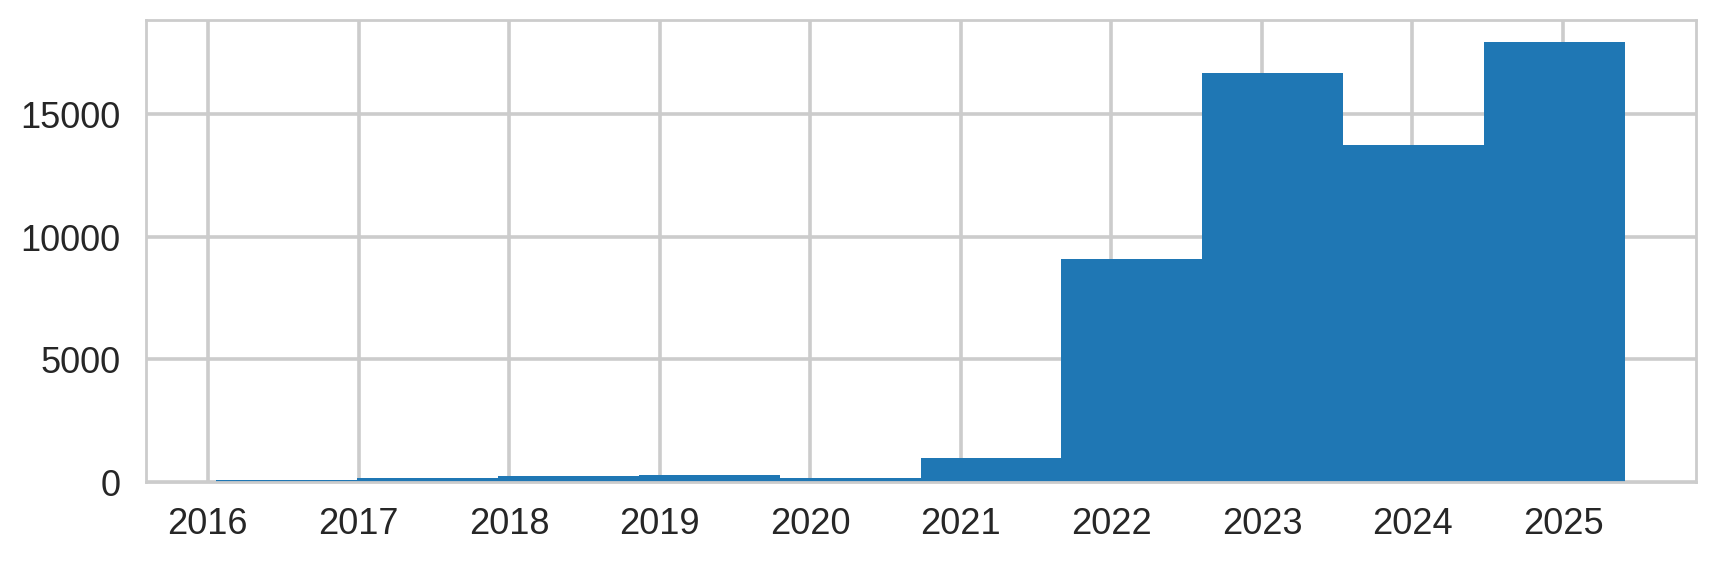

In [21]:
# Not very appealing
inspections["INSPECTION_DATE"].hist(figsize=(10,3))

<Axes: >

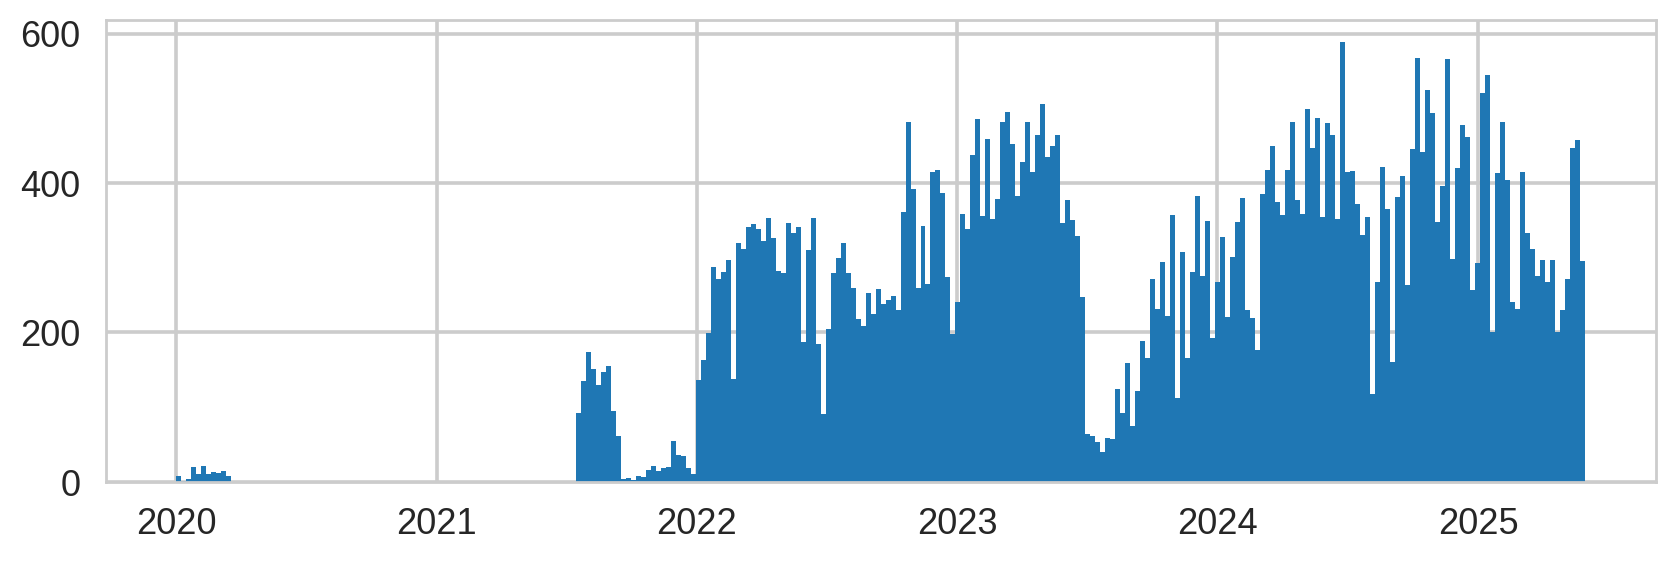

In [32]:
from datetime import date

start_date = date(2020, 1, 1)
end_date = date(2025, 5, 31)
time_difference = end_date - start_date
number_of_weeks = time_difference.days // 7

inspections["INSPECTION_DATE"].hist(
    range=(start_date , end_date),  # limit the range of dates
    bins=number_of_weeks,  # number of week in the range
    figsize=(10, 3),  # resize 10-width, 3-height
)

### Descriptive Statistics for Categorical/string columns

We can also get quick statistics about the common values that appear in each column:

In [33]:
restaurants["CUISINE_DESCRIPTION"].value_counts()

,count
CUISINE_DESCRIPTION,
American,4042
Chinese,1707
Coffee/Tea,1668
Pizza,1314
Mexican,822
...,...
Czech,2
Basque,2
Iranian,2


In [34]:
# Let's keep just the top-10
restaurants["CUISINE_DESCRIPTION"].value_counts().head(10)

,count
CUISINE_DESCRIPTION,
American,4042
Chinese,1707
Coffee/Tea,1668
Pizza,1314
Mexican,822
Italian,816
Latin American,754
Bakery Products/Desserts,744
Japanese,711


And we can use the "plot" command to plot the resulting histogram. ([More details](http://pandas.pydata.org/pandas-docs/stable/visualization.html))

<Axes: ylabel='CUISINE_DESCRIPTION'>

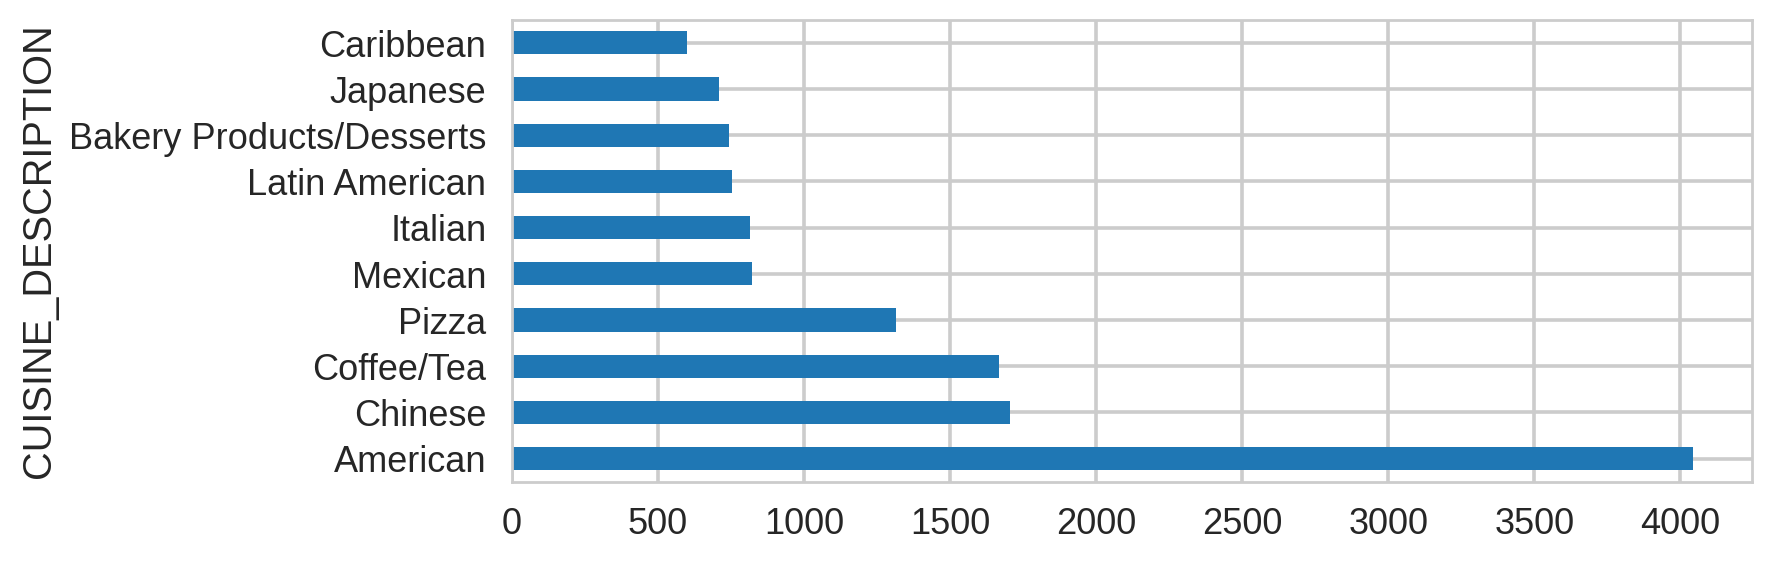

In [35]:
# We use a horizontal bar chart, aka "barh",
# to make the text labels easier to read
restaurants["CUISINE_DESCRIPTION"].value_counts().head(10).plot(kind="barh", figsize=(8,3))

<Axes: ylabel='CUISINE_DESCRIPTION'>

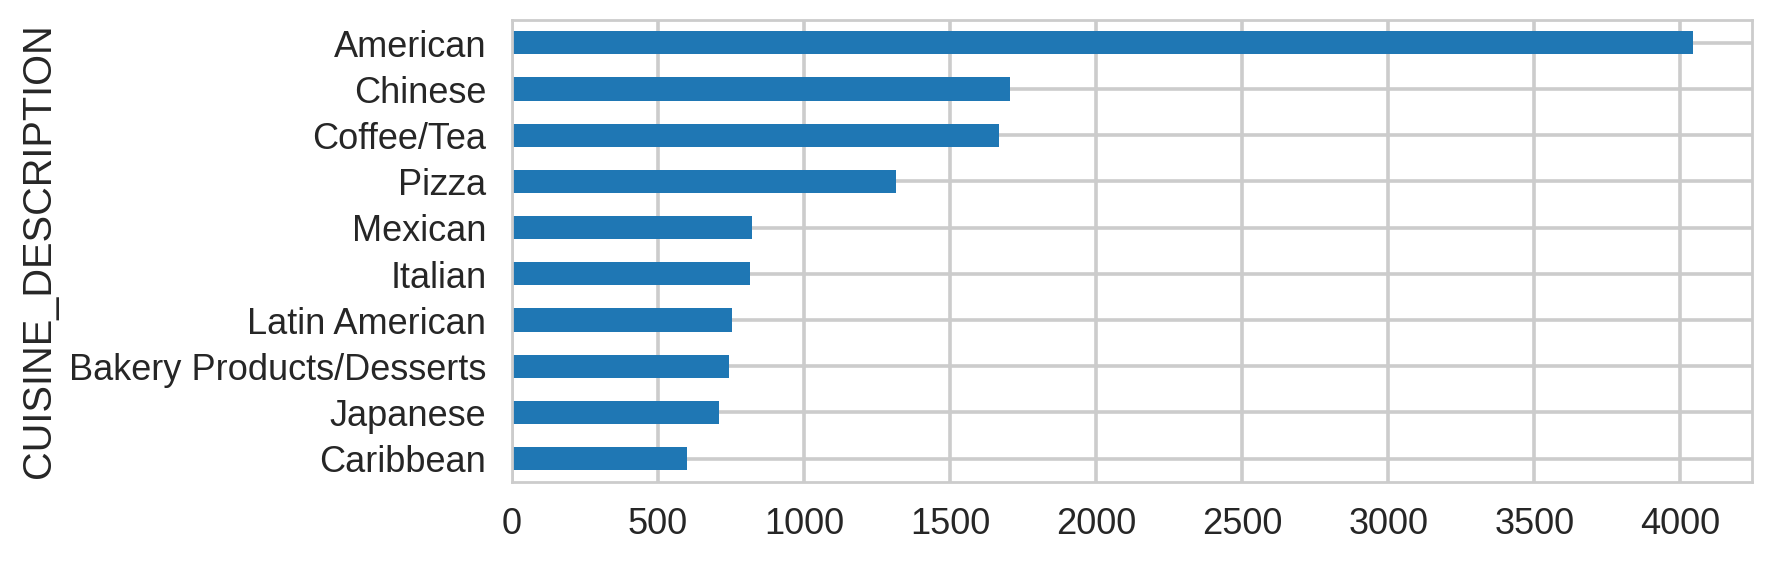

In [36]:
restaurants["CUISINE_DESCRIPTION"].value_counts().head(10).sort_values().plot(kind="barh", figsize=(8,3))

#### Exercise

Create a plot with the frequency of restaurant names (i.e., `DBA` variable in the `restaurants` dataframe). Which chains have the most restaurants in NYC? How does the list for the whole NYC compare to the list for Manhattan (ie analyze the `restaurants` and the `manh_rest` dataframes)

#### Exercise

Using the "violations" dataframe, analyze the `VIOLATION_CODE` attribute and identify the most common violation codes in the data. Create a bar plot as above to show the frequency of the various violations codes.

If you are adventurous, issue a query against the database using the `read_sql` command and get the descriptions of the violations from the table `doh_restaurants.violaction_codes` for the most common violation codes that are included in the plot above.

#### Solution

In [ ]:
violations["VIOLATION_CODE"].value_counts().head(10).plot(kind='barh', figsize=(8,3))

In [ ]:
violations["VIOLATION_CODE"].value_counts().head(10).sort_values().plot(kind='barh', figsize=(8,3))

In [ ]:
with engine.connect() as connection:
  sql = "SELECT * FROM violation_codes"
  codes = pd.read_sql(text(sql), con=connection)
codes

#### Exercise

* Create a plot showing the number of restaurants across **zipcodes** and **boroughts**. Use the `ZIPCODE` and `BORO` columns and the `value_counts()` function.

In [ ]:
# your code here

In [ ]:
# your code here